Step 1: Brief description of the problem and data

The goal of this competition is to develop an algorithm to identify metastatic cancer. The dataset is based on a modified version of the PatchCamelyon (PCam) benchmark dataset. This is a binary image classification task.

1. **Data Size** : The dataset includes test and train folders that contain image files in tif format. The training data set has 220025 unique values. The test data set has 57458 unique values.
2. **Dimensions** : Each image has a fixed size, consisting of a central region (32x32 pixels) and an outer region. The central region decides the label value, while the outer enables fully-convolutional models that do not use zero-padding.
3. **Structures** : \
    3-1 **image** : The name of each image file is its id \
    3-2 **csv** : The train_labels.csv has 2 columns: id and label. The expectation is to create a test.csv that also outputs the same two columns. \
    3-3 **labels** : Label 1 indicates that the central region of the image contains at least one tumor tissue pixel while Label 0 indicates a negative result. 

Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Total images: 220025
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Number of duplicate IDs: 0


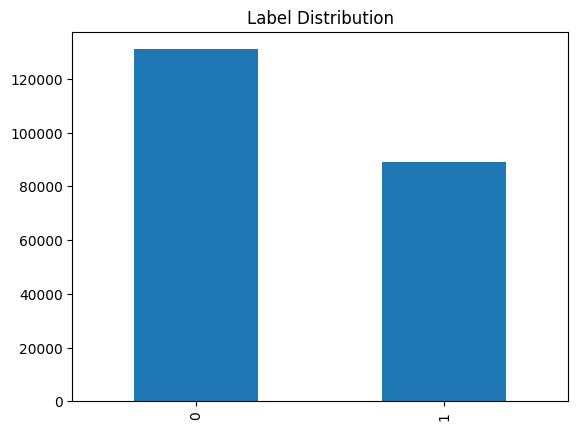

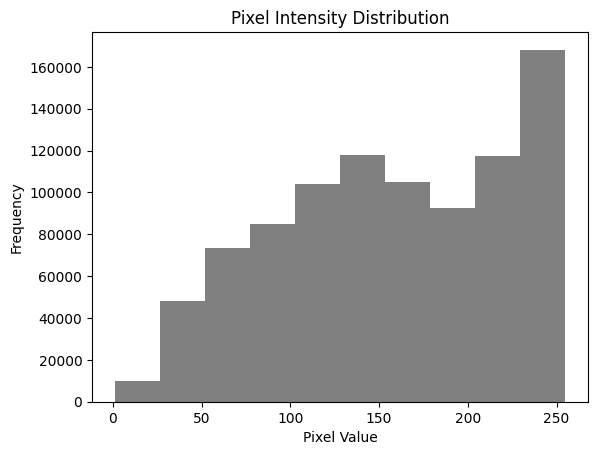

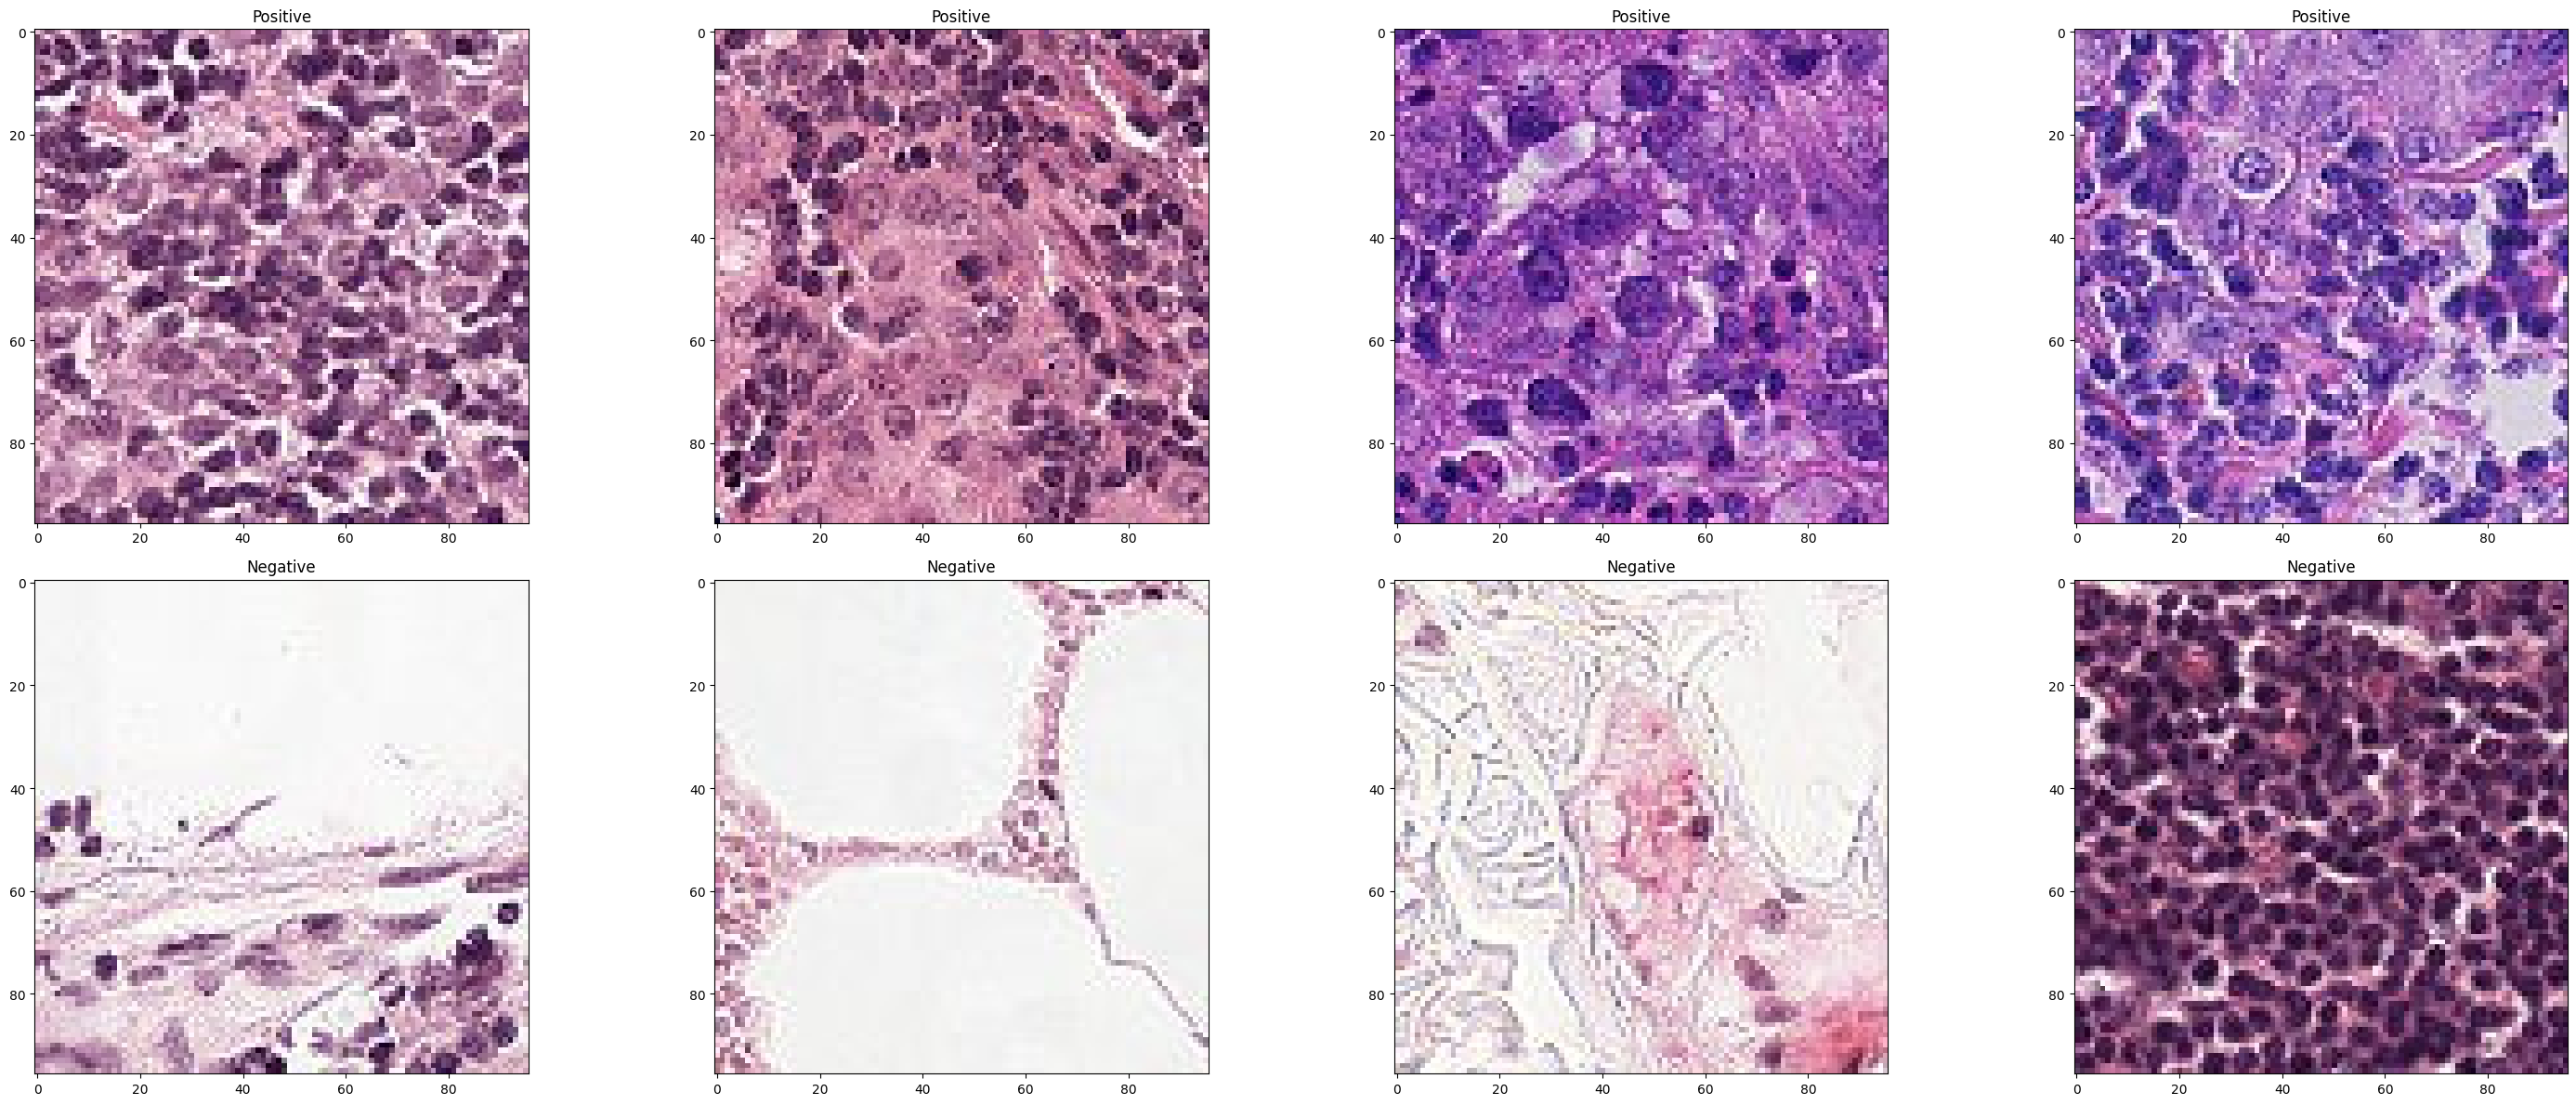

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob

train_labels = pd.read_csv('data/hcd/train_labels.csv')
print(f"Total images: {len(train_labels)}")


print(train_labels.head())       
print(train_labels.info())        
print(train_labels.describe()) 

duplicates = train_labels.duplicated(subset='id')
print(f"Number of duplicate IDs: {duplicates.sum()}")

train_labels['label'].value_counts(normalize=True)

train_labels['label'].value_counts().plot(kind='bar', title='Label Distribution')
plt.show()


# displaying distribution of pixels 0 - 255
def plot_pixel_histogram(image_folder, labels_df, num_samples=100):
    pixel_values = []
    for img_id in labels_df.sample(num_samples)['id']:
        img_path = os.path.join(image_folder, img_id + '.tif')
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        pixel_values.extend(img.flatten())
    
    plt.hist(pixel_values, bins=10, color='gray')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

plot_pixel_histogram('data/hcd/train', train_labels)


# displaying numbers of sample images for positive and negative labels
def plot_sample_images(image_folder, labels_df, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(30, 12))
    for i in range(num_samples):
        positive_img = labels_df[labels_df['label'] == 1].sample(1)
        negative_img = labels_df[labels_df['label'] == 0].sample(1)
        
        pos_img_path = os.path.join(image_folder, positive_img['id'].values[0] + '.tif')
        neg_img_path = os.path.join(image_folder, negative_img['id'].values[0] + '.tif')
        
        pos_img = cv2.imread(pos_img_path)
        neg_img = cv2.imread(neg_img_path)
        
        axes[0, i].imshow(cv2.cvtColor(pos_img, cv2.COLOR_BGR2RGB))
        axes[0, i].set_title('Positive')
        axes[1, i].imshow(cv2.cvtColor(neg_img, cv2.COLOR_BGR2RGB))
        axes[1, i].set_title('Negative')
    
    plt.tight_layout()
    plt.show()

plot_sample_images('data/hcd/train', train_labels)

![Sample Image](resources/week3_hcd_charts.png)
![Sample Image](resources/week3_hcd_image.png)

Step 3: DModel Architecture

1. When viewing pre-trained models on https://keras.io/api/applications/, RestNet50V2 provides high accuracy while its computational resource requirements are moderate. It balances efficiency and accuracy in my opinion. Using pre-trained weights from ImageNet dataset should be a good starting point for faster training and better generalization. EfficientNetB0 is chosen to be its comparison. It has fewer parameters and lower computational cost with slightly better accuracy. One of these will be chosen for tuning based on the performance and time consumption
2. The discussion forum on Kaggle https://www.kaggle.com/competitions/histopathologic-cancer-detection/discussion/81747 suggested albumentions for image augmentations \
    2.1 **Resize**: Resize the image to the default size on ImageNet \
    2.2 **RandomRotate90**: Randomly rotate the image by 90 degrees with 50% of chance that an image will be rotated \
    2.3 **Transpose**: Transpose the image by swapping rows and columns with 50% of chance that an image will be transposed \
    2.4 **Flip**: Randomly flip the image either horizontally or vertically with 50% of chance that an image will be flipped \
    2.5 **OneOf**: Use one of the listed transformations with 50% of chance that the picked transformation will be applied on an image\
      2.5.1 Contrast Limited Adaptive Histogram Equalization with a clip limit of 2 \
      2.5.2 Sharpening images \
      2.5.3 Embossing images \
      2.5.4 Randomly adjusting the brightness and contrast of the image \
      2.5.5 Image compression \
      2.5.6 Blur effect \
      2.5.7  Adding Gaussian noise \
    2.6 **HueSaturationValue**: It randomly changes the hue, saturation, and value with 50% of chance that an image will be chosen for it \
    2.7 **ShiftScaleRotate**: It randomly shifts, scales, and rotates the image with 50% of chance that an image will be chosen for it \
    2.8 **Normalize**: Subtract the mean and dividing by the standard deviation \
3. We need  **load_and_preprocess_image** to process each image from the train folder
4. We use train_test_split to have 80% of training data for training, and 20% for testing.
5. Google Collab free version does not provide efficient CPU, so a high number of batch, i.e. 256, will crash the system. Therefore, we start with 32 images for a batch.
6. When generating model, set outputting layer false for binary classification. Use sigmoid as actiivation. **global average pooling (GAP)**  reduces the spatial dimensions of the feature maps while preserving the most important information.
7. Each model uses ADAM to update the model's weights based on the gradients. We track the accuracy to evaluate the performance. ReduceLROnPlateau callback will reduce the learning rate when the validation. \
    7.1  **val_loss**: Use validation loss as a monitor. \
    7.2  With **factor = 0.1**, the learning rate will be reduced by 90% if the condistion: the validation loss does not improve for 2 consecutive epochs (**patience=2**), meets.  \
    7.3 **verbose=1** will print out information when the learning rate is reduced.
8. Use **ModelCheckpoint** to save the weights that contribute to the best performance. 
9. Use **Model.fit** to train the model with the data generator, dataset, epochs and callback functions defined earlier 

Here is the log for five epochs:
```
Epoch 1/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6883 - loss: 0.5880
320/320 ━━━━━━━━━━━━━━━━━━━━ 6534s 20s/step - accuracy: 0.6884 - loss: 0.5879 - val_accuracy: 0.5949 - val_loss: 1.5710 - learning_rate: 5.0000e-04

Epoch 2/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.7910 - loss: 0.4429
320/320 ━━━━━━━━━━━━━━━━━━━━ 3177s 10s/step - accuracy: 0.7910 - loss: 0.4428 - learning_rate: 5.0000e-04

Epoch 3/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8233 - loss: 0.4060
320/320 ━━━━━━━━━━━━━━━━━━━━ 3100s 10s/step - accuracy: 0.8233 - loss: 0.4059 - learning_rate: 5.0000e-04

Epoch 4/5
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8366 - loss: 0.3756
Epoch 4: saving model to /content/drive/My Drive/best_model.keras
320/320 ━━━━━━━━━━━━━━━━━━━━ 3117s 10s/step - accuracy: 0.8366 - loss: 0.3755 - learning_rate: 5.0000e-04

Epoch 5/5
235/320 ━━━━━━━━━━━━━━━━━━━━ 14:22 10s/step - accuracy: 0.8553 - loss: 0.3359
```

In [17]:
from keras.applications import ResNet50V2, EfficientNetB0
from keras.models import Model
import os
import albumentations as A
from albumentations import Compose, Resize, RandomRotate90, Transpose, Flip, OneOf, CLAHE, Sharpen, Emboss, RandomBrightnessContrast, ImageCompression, Blur, GaussNoise, HueSaturationValue, ShiftScaleRotate, Normalize
from albumentations.augmentations.transforms import ToFloat
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tifffile


TRAIN_PATH = "data/hcd/train"
TRAIN_LABEL_PATH = "data/hcd/train_labels"

augment_pipeline = A.Compose([ A.Resize(224, 224), A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.Flip(p=0.5), A.OneOf([ A.CLAHE(clip_limit=2), A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0)), A.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7)), A.RandomBrightnessContrast(), A.ImageCompression(quality_lower=30, quality_upper=100), A.Blur(), A.GaussNoise() ], p=0.5), A.HueSaturationValue(p=0.5), A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=45, p=0.5), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

def load_and_preprocess_image(image_path, label, augment=False):
    image = tifffile.imread(image_path)
    # image = tf.image.decode_image(image_data, channels=3)
    if augment:
        augmented = augment_pipeline(image=image)
        image = augmented['image']
        
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    image = tf.convert_to_tensor(image / 255.0, dtype=tf.float32)
    label = label
    return image, label

labels_df = pd.read_csv(TRAIN_LABEL_PATH)
image_paths = [os.path.join(TRAIN_PATH, f"{image_id}.tif") for image_id in labels_df['id']]

labels = labels_df['label'].values

# Split data into training and validation sets
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

def image_generator(image_paths, labels, batch_size, augment=False):
    batch_images = []
    batch_labels = []
    
    for image_path, label in zip(image_paths, labels):
        image, label = load_and_preprocess_image(image_path, label, augment=augment)
        batch_images.append(image)
        batch_labels.append(label)
        
        if len(batch_images) == batch_size:  
            yield tf.stack(batch_images), tf.convert_to_tensor(batch_labels)
            batch_images, batch_labels = [], []  
    
    if len(batch_images) > 0:  
        yield tf.stack(batch_images), tf.convert_to_tensor(batch_labels)

def create_model_resnet50():
    base_model = ResNet50V2(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

def create_model_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
    return model

def train_and_validate_model(model, train_generator, val_generator, optimizer, num_epochs=20):
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Learning rate scheduler callback
    scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

    # Model checkpoint callback to save the best model
    checkpoint = ModelCheckpoint(
        "best_model.keras", 
        monitor="val_loss", 
        save_best_only=True, 
        verbose=1
    )

    # Train the model using Keras' built-in fit method
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=num_epochs,
        callbacks=[scheduler, checkpoint],
        verbose=1
    )

    print("Training complete.")
    return history




train_generator = image_generator(train_image_paths, train_labels, batch_size=32, augment=True)
val_generator = image_generator(val_image_paths, val_labels, batch_size=64, augment=False)

model_resnet50 = create_model_resnet50()
optimizer_resnet50 = tf.keras.optimizers.Adam(learning_rate=0.0009) 
best_acc_resnet50 = train_and_validate_model(model_resnet50, train_generator, val_generator, optimizer_resnet50)

model_efficientnet = create_model_efficientnet()
optimizer_efficientnet = tf.keras.optimizers.Adam(learning_rate=0.0009) 
best_acc_efficientnet = train_and_validate_model(model_efficientnet, train_generator, val_generator, optimizer_efficientnet)

print(f"ResNet50V2 Best Val Accuracy: {best_acc_resnet50:.4f}")
print(f"EfficientNetB0 Best Val Accuracy: {best_acc_efficientnet:.4f}")




102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Step 4: Results and Analysis
1. To improve the efficiency, we go with K_folds. The ideal scenario is to change the parameter of learning rates and models trained from the previous steps. However, training two models with 20 folds and 10 epochs is impossible with the given resources on Google Colab free version. The Plan B here is to go with the newer model EfficientNetB0.
2. k_folds is used for for cross-validation. The entire dataset is split into 20 equally sized folds. For each iteration, the model is trained using 19 of these folds and the remaining fold is used for validation.  This process is repeated 20 times, each time using a different fold as the validation set and the remaining folds as the training set. 
With 5 hours on Google Colab, here are the logs: 

        ```
                        Training Fold 1/5 with learning rate 0.0005
                Steps fer epoch 687 and validation steps: 1375
                Epoch 1/5
                687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6987 - loss: 0.5653 
                Epoch 1: saving model to /content/drive/My Drive/best_model_fold_1_lr_0.0005.keras
                687/687 ━━━━━━━━━━━━━━━━━━━━ 9859s 14s/step - accuracy: 0.6987 - loss: 0.5652 - val_accuracy: 0.5949 - val_loss: 1.0568 - learning_rate: 5.0000e-04
                Epoch 2/5
                687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8136 - loss: 0.4128
                Epoch 2: saving model to /content/drive/My Drive/best_model_fold_1_lr_0.0005.keras

                /usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
                self.gen.throw(typ, value, traceback)

                687/687 ━━━━━━━━━━━━━━━━━━━━ 6363s 9s/step - accuracy: 0.8136 - loss: 0.4127 - val_accuracy: 0.6000 - val_loss: 661.4323 - learning_rate: 5.0000e-04
                Epoch 3/5
                687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8315 - loss: 0.3797
                Epoch 3: saving model to /content/drive/My Drive/best_model_fold_1_lr_0.0005.keras

                /usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
                callback.on_epoch_end(epoch, logs)

                687/687 ━━━━━━━━━━━━━━━━━━━━ 6336s 9s/step - accuracy: 0.8315 - loss: 0.3797 - learning_rate: 5.0000e-04
                Epoch 4/5
                687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8444 - loss: 0.3531
                Epoch 4: saving model to /content/drive/My Drive/best_model_fold_1_lr_0.0005.keras
                687/687 ━━━━━━━━━━━━━━━━━━━━ 6350s 9s/step - accuracy: 0.8444 - loss: 0.3531 - learning_rate: 5.0000e-04
                Epoch 5/5
                687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8506 - loss: 0.3421
                Epoch 5: saving model to /content/drive/My Drive/best_model_fold_1_lr_0.0005.keras
                687/687 ━━━━━━━━━━━━━━━━━━━━ 6375s 9s/step - accuracy: 0.8506 - loss: 0.3421 - learning_rate: 5.0000e-04
                Fold 1, Learning Rate 0.0005: Best Validation Accuracy = 0.6000
                Training Fold 2/5 with learning rate 0.0005
                Steps fer epoch 687 and validation steps: 1375
        ```
3. The learning rate 0.0005 seems to perform better in the first two iterations. The accuracy can probably get higher if all iterations can be completed.



In [ ]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

k_folds = 20
learning_rates = [0.0001, 0.0005]
batch_size = 32
num_epochs = 10

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_image_paths)):
    for learning_rate in learning_rates:
        print(f"Training Fold {fold+1}/{k_folds} with learning rate {learning_rate}")
        train_generator = image_generator(
        [train_image_paths[i] for i in train_idx], 
        [train_labels[i] for i in train_idx],
        batch_size=batch_size, 
        augment=True
        )
        val_generator = image_generator(
            [train_image_paths[i] for i in val_idx], 
            [train_labels[i] for i in val_idx],
            batch_size=batch_size, 
            augment=False
        )

        steps_per_epoch = len(train_idx) // batch_size
        validation_steps = len(val_idx) // batch_size   
        print(f"Steps fer epoch {steps_per_epoch} and validation steps: {validation_steps}")

        model_file = f"/content/drive/My Drive/best_model_fold_{fold+1}_lr_{learning_rate}.keras"
        if os.path.exists(model_file):
            print(f"Loading saved model for fold {fold+1} with learning rate {learning_rate}")
            model_efficientnet = load_model(model_file) 
        else:
            model_efficientnet = create_model_efficientnet()

        optimizer = Adam(learning_rate=learning_rate)
        model_efficientnet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=2, verbose=1)
        checkpoint = ModelCheckpoint(
            f"/content/drive/My Drive/best_model_fold_{fold+1}_lr_{learning_rate}.keras", 
            monitor="val_loss", 
            save_best_only=True, 
            verbose=1
        )

        history = model_efficientnet.fit(
        train_generator,
        validation_data=val_generator,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[scheduler, checkpoint],
        verbose=1
        )

        best_val_acc = max(history.history['val_accuracy'])
        fold_results.append((fold, learning_rate, best_val_acc))
        print(f"Fold {fold+1}, Learning Rate {learning_rate}: Best Validation Accuracy = {best_val_acc:.4f}")


fold_results = sorted(fold_results, key=lambda x: (x[0], x[1]))  # Sort by fold and learning rate
learning_rates_str = [f"LR {lr}" for lr in learning_rates]
print("KFold results:", fold_results)
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    accs = [result[2] for result in fold_results if result[1] == lr]
    plt.plot(range(1, k_folds + 1), accs, marker='o', label=f"LR {lr}")

plt.title("K-Fold Cross-Validation Results")
plt.xlabel("Fold")
plt.ylabel("Best Validation Accuracy")
plt.legend()
plt.grid()
plt.show()







Step 5: Conclusion

1. Training ResNet50V2 without specifying expected steps and using small batch sizes due to limited computational resources proved inefficient. Google Colab automatically terminated the session after 9 hours, with the model achieving a maximum accuracy of 74% (1569/Unknown, 32542s, 21s/step - accuracy: 0.7460, loss: 0.5297) without completing the first epoch.

2. Model performance could improve significantly with larger batch sizes (e.g., 254), additional epochs, and well-defined training steps. Incorporating advanced cross-validation techniques, such as k-fold cross-validation, would further enhance model robustness. However, achieving these improvements requires access to more powerful computational resources, such as high-performance CPUs and GPUs.

3. In addition to larger batch sizes, longer training epochs, and k-fold cross-validation, tools like ***ReduceLROnPlateau*** and ***callbacks*** such as ModelCheckpoint can significantly improve training efficiency and model performance. \
    3.1 ***ReduceLROnPlateau***: This learning rate scheduler dynamically adjusts the learning rate during training based on validation loss. By reducing the learning rate when the validation loss plateaus, the model can fine-tune its parameters more effectively, preventing overfitting. \
    3.2 ***ModelCheckpoint***: This callback ensures that the best-performing model is saved automatically based on a specified metric (in this case validation loss). This eliminates the risk of losing progress in case of interruptions or disconnections, especially in environments like Google Colab where session time is limited.

Together, these tools allow for a better model by optimizing resource usage and preserving the best results, even with limited hardware.
 

In [ ]:
* use model to predict the test folder 

In [ ]:
import os
import pandas as pd
import tifffile
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model
model = load_model("/content/drive/My Drive/best_model_fold_1_lr_0.0005.keras")
TEST_PATH = "dataset/test"

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, augment=False):
    try:
        image = tifffile.imread(image_path)
        if augment:
            augmented = augment_pipeline(image=image)
            image = augmented['image']

        image = tf.image.resize(image, (224, 224))
        image = tf.convert_to_tensor(image / 255.0, dtype=tf.float32)
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Image generator for test data (no labels)
def image_generator(image_paths, batch_size=32, augment=False):
    batch_images = []
    batch_paths = []

    for image_path in image_paths:
        image = load_and_preprocess_image(image_path, augment=augment)
        if image is None:  # Skip invalid files
            continue

        batch_images.append(image)
        batch_paths.append(image_path)

        if len(batch_images) == batch_size:  # Yield batch when size is reached
            yield tf.stack(batch_images), batch_paths
            batch_images = []
            batch_paths = []

    if len(batch_images) > 0:  # Yield remaining images
        yield tf.stack(batch_images), batch_paths

# Collect all test image paths
test_image_paths = [
    os.path.join(TEST_PATH, filename) for filename in os.listdir(TEST_PATH) if filename.endswith(".tif")
]
print(f"Total test files: {len(test_image_paths)}")

# Predict and save results
results = []
batch_size = 32

for batch_idx, (batch_images, batch_paths) in enumerate(image_generator(test_image_paths, batch_size=batch_size, augment=False)):
    print(f"Processing batch {batch_idx + 1}...")

    # Model prediction
    predictions = model.predict(batch_images)

    # Process predictions
    for i, prediction in enumerate(predictions):
        image_id = os.path.splitext(os.path.basename(batch_paths[i]))[0]
        label = 1 if prediction[0] >= 0.5 else 0
        results.append({"id": image_id, "label": label})
        print(f"Image ID: {image_id}, Predicted Label: {label}")

# Save results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/My Drive/submission-3.csv", index=False)

print(f"Saved predictions for {len(results)} images.")

reloaded_df = pd.read_csv("/content/drive/My Drive/submission-3.csv")
print(f"Number of rows in the saved CSV file: {len(reloaded_df)}")
